In [1]:
import pandas as pd

#species df
species = pd.read_csv('species_info.csv')

print(species.columns)
print(species.count())
print(species.describe())

#detect % missing data
maxRows = species['category'].count()
 
print('% Missing Data:')
print((1 - species.count() / maxRows) * 100)

#replace missing data as 'No Intervention'
species.fillna('No Intervention', inplace=True)
species.groupby("conservation_status").size()

Index(['category', 'scientific_name', 'common_names', 'conservation_status'], dtype='object')
category               5824
scientific_name        5824
common_names           5824
conservation_status     191
dtype: int64
              category    scientific_name        common_names  \
count             5824               5824                5824   
unique               7               5541                5504   
top     Vascular Plant  Castor canadensis  Brachythecium Moss   
freq              4470                  3                   7   

       conservation_status  
count                  191  
unique                   4  
top     Species of Concern  
freq                   161  
% Missing Data:
category                0.000000
scientific_name         0.000000
common_names            0.000000
conservation_status    96.720467
dtype: float64


conservation_status
Endangered              16
In Recovery              4
No Intervention       5633
Species of Concern     161
Threatened              10
dtype: int64

In [2]:
observations = pd.read_csv('observations.csv')

print(observations.columns)
print(observations.count())
print(observations.describe())

Index(['scientific_name', 'park_name', 'observations'], dtype='object')
scientific_name    23296
park_name          23296
observations       23296
dtype: int64
       observations
count  23296.000000
mean     142.287904
std       69.890532
min        9.000000
25%       86.000000
50%      124.000000
75%      195.000000
max      321.000000


In [3]:
#merge two dfs
df = pd.merge(species, observations, how='outer', on=['scientific_name'])

print(df.head())
print(df.columns)
print(df.count())
print(df.describe())

  category                scientific_name              common_names  \
0   Mammal  Clethrionomys gapperi gapperi  Gapper's Red-Backed Vole   
1   Mammal  Clethrionomys gapperi gapperi  Gapper's Red-Backed Vole   
2   Mammal  Clethrionomys gapperi gapperi  Gapper's Red-Backed Vole   
3   Mammal  Clethrionomys gapperi gapperi  Gapper's Red-Backed Vole   
4   Mammal                      Bos bison     American Bison, Bison   

  conservation_status                            park_name  observations  
0     No Intervention                  Bryce National Park           130  
1     No Intervention            Yellowstone National Park           270  
2     No Intervention  Great Smoky Mountains National Park            98  
3     No Intervention               Yosemite National Park           117  
4     No Intervention               Yosemite National Park           128  
Index(['category', 'scientific_name', 'common_names', 'conservation_status',
       'park_name', 'observations'],
      dty

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

conservationCategory = species[species.conservation_status != "No Intervention"]\
    .groupby(["conservation_status", "category"])['scientific_name']\
    .count()\
    .unstack()

conservationCategory


category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,7.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,1.0,NaN,NaN,NaN
Species of Concern,4.0,72.0,4.0,28.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


Text(0, 0.5, 'Number of Species')

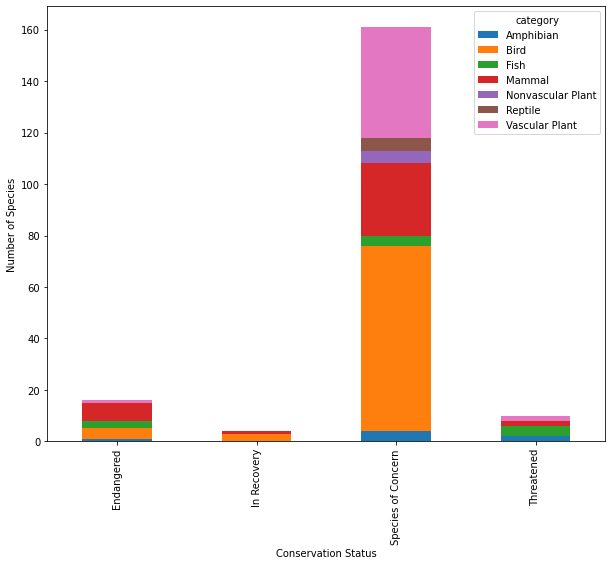

In [34]:
ax = conservationCategory.plot(kind = 'bar', figsize=(10,8), 
    stacked=True)
ax.set_xlabel("Conservation Status")
ax.set_ylabel("Number of Species")

In [17]:
species['is_protected'] = species.conservation_status != 'No Intervention'

#Pivot Table: Protected vs Not Protected
category_counts = species.groupby(['category', 'is_protected'])\
.scientific_name.nunique()\
.reset_index()\
.pivot(columns='is_protected',
    index='category',
    values='scientific_name')\
    .reset_index()
category_counts.columns = ['category', 'not_protected', 'protected']

#Percentage Column
category_counts['percent_protected'] = category_counts.protected / (category_counts.protected + category_counts.not_protected) * 100

category_counts

,category,not_protected,protected,percent_protected
0,Amphibian,72,7,8.860759
1,Bird,413,75,15.368852
2,Fish,115,11,8.730159
3,Mammal,146,30,17.045455
4,Nonvascular Plant,328,5,1.501502
5,Reptile,73,5,6.410256
6,Vascular Plant,4216,46,1.079305


In [26]:
from itertools import chain
import string

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

common_Names = species[species.category == "Mammal"]\
    .common_names\
    .apply(remove_punctuations)\
    .str.split().tolist()

common_Names[:6]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison', 'Bison'],
 ['Aurochs',
  'Aurochs',
  'Domestic',
  'Cattle',
  'Feral',
  'Domesticated',
  'Cattle'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Sheep', 'Sheep', 'Feral'],
 ['Wapiti', 'Or', 'Elk'],
 ['WhiteTailed', 'Deer']]

In [31]:
cleanRows = []

for item in common_Names:
    item = list(dict.fromkeys(item))
    cleanRows.append(item)



res = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in cleanRows))


words_counted = []

for i in res:
    x = res.count(i)
    words_counted.append((i,x))

pd.DataFrame(set(words_counted), columns =['Word', 'Count']).sort_values("Count", ascending = False).head(10)

,Word,Count
11,Bat,23
122,Shrew,18
86,Myotis,17
188,Mouse,16
199,Chipmunk,13
84,American,12
105,Squirrel,12
121,Vole,11
5,Eastern,11
75,Western,10


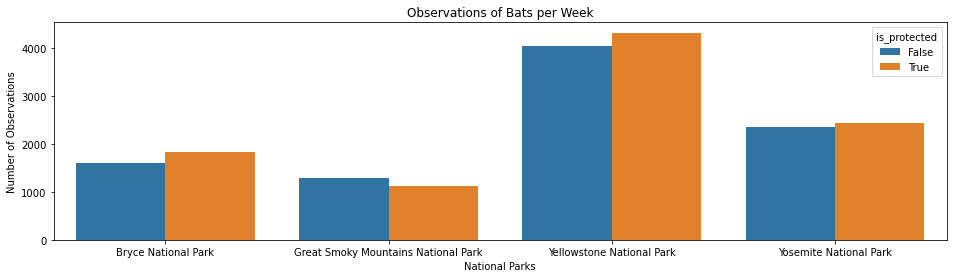

<Figure size 432x288 with 0 Axes>

In [33]:
species['is_bat'] = species.common_names.str.contains(r"\bBat\b", regex = True)

bat_observations = observations.merge(species[species.is_bat])

bat_observations.groupby('park_name').observations.sum().reset_index()

obs_by_park = bat_observations.groupby(['park_name', 'is_protected']).observations.sum().reset_index()

plt.figure(figsize=(16, 4))
sns.barplot(x=obs_by_park.park_name, y= obs_by_park.observations, hue=obs_by_park.is_protected)
plt.xlabel('National Parks')
plt.ylabel('Number of Observations')
plt.title('Observations of Bats per Week')
plt.show()
plt.clf()